# SKin Segmentation using deep learning

In [1]:
# Importing the libraries
import numpy as np
from matplotlib import pyplot as plt
import torch.utils.data as data_utils

import torch
import torchvision
from torchvision import datasets,models, transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'# !pip install torchsummary 
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark=True
import os


# Loading the Training and Testing Data using Data Loader with Data Augmentation



In [2]:
X_train = np.load('./Umbilicus_Skin_Detection/code/X_train.npy').astype('float32')
Y_train = np.load('./Umbilicus_Skin_Detection/code/Y_train.npy')
X_test = np.load('./Umbilicus_Skin_Detection/code/X_test.npy')
Y_test = np.load('./Umbilicus_Skin_Detection/code/Y_test.npy')


## Normalizing  the data using the Formula (x-xmin/(xmax-xmin)) across each column

In [3]:
# # Normalizing the data by using the Formula (x-xmin/(xmax-xmin))
# normx_=(adultdata-adultdata.min(axis=0))/(adultdata.max(axis=0)-adultdata.min(axis=0))

## Splitting and Loading Data in Data Loader
* Train Data Loader has shuffle = True, so that it can shuffle data in each minibatch every epoch. 

In [4]:
# Splitting the Data into Training and Test Data
# X_train, X_test,Y_train,Y_test = train_test_split(normadultdata,adultlabels, test_size=0.15, shuffle = True)

# batch_size
batch = 16
# Train Data Loader
train = data_utils.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())
train_loader = data_utils.DataLoader(train, batch_size=batch, shuffle=True)

# Test Data loader
test = data_utils.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).float())
test_loader = data_utils.DataLoader(test,batch_size=batch)

# Showing the Training Data after Normalizing

In [5]:
# Preview the training data
for batch_idx, (data, target) in enumerate(train_loader):
#     print(batch_idx)
    print("Training Data")
    print(data[0])
    print("Testing Label")
    print(target[0].item())
    break
    

Training Data
tensor([55., 98., 72.,  ..., 78., 74., 64.])
Testing Label
1.0


In [6]:
target.dtype

torch.float32

## Defining a Linear Neural Network
* A simple fully connected network was used with activation function like ReLU and PReLU. 
* PReLU was used as it increased the accuracy, although this was very experimental, as replacing all the ReLUs by PreLU significantly reduce the accuracy.
* As this is a binary classification problem, Sigmoid Activation is Used in the final layer.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2000, 256)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 32)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(32, 1)
        self.out_act = nn.Sigmoid()
    
    def swish(self,x):
        return x * torch.sigmoid(x)
        
    def forward(self, input_):
        inp = self.fc1(input_)
        x = self.relu1(inp)
        x = self.dout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dout2(x)
        x = self.fc3(x)
        x = self.prelu(x)
        x = self.out(x)
        y = (self.out_act(x))
        return y
net = Net()
net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
torch.backends.cudnn.benchmark = True
net

DataParallel(
  (module): Net(
    (fc1): Linear(in_features=2000, out_features=256, bias=True)
    (relu1): ReLU()
    (dout): Dropout(p=0.2)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (relu2): ReLU()
    (dout2): Dropout(p=0.2)
    (fc3): Linear(in_features=128, out_features=32, bias=True)
    (prelu): PReLU(num_parameters=1)
    (out): Linear(in_features=32, out_features=1, bias=True)
    (out_act): Sigmoid()
  )
)

In [8]:
summary(net,input_size = (1,2000),batch_size=batch)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [16, 1, 256]         512,256
            Linear-2               [16, 1, 256]         512,256
              ReLU-3               [16, 1, 256]               0
              ReLU-4               [16, 1, 256]               0
           Dropout-5               [16, 1, 256]               0
           Dropout-6               [16, 1, 256]               0
            Linear-7               [16, 1, 128]          32,896
            Linear-8               [16, 1, 128]          32,896
              ReLU-9               [16, 1, 128]               0
             ReLU-10               [16, 1, 128]               0
          Dropout-11               [16, 1, 128]               0
          Dropout-12               [16, 1, 128]               0
           Linear-13                [16, 1, 32]           4,128
           Linear-14                [16

## Defining Convolution Neural Network
* Initially I tried using 2 and 3 layer convolutions with dropout(0.5) and batchregularization, but the accuracy varied between 69 - (75, 77 ) percent. Later on I shifted to VGG networks which gave better accuracy. 
* After Implementing different VGG Networks, VGG13 gave the best results. 



In [9]:
# # Code Modified from  https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
# config = {
#     'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512 ,512, 'M', 512, 512, 'M'],
#     'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
#     'VGG19': [64, 64, 'M', 128,'D', 128, 'M', 256,'D', 256, 256, 256, 'M', 512,'D', 512, 512, 512, 'M', 512,'D', 512, 512, 512, 'M'],
# }


# class VGG(nn.Module):
#     def __init__(self, vgg_name):
#         super(VGG, self).__init__()
#         self.conv = self._make_layers(config[vgg_name])
#         self.linear = self._make_layers_linear()

#     def forward(self, x):
#         out = self.conv(x)
#         out = out.view(out.size(0), -1)
#         out = self.linear(out)
#         return out
    
#     def vis(self, x):
#         out = self.conv(x)
#         return out
    
#     def swish(self,x):
#         return x * torch.sigmoid(x) # Tried using this, but as the error did not converge, not used later on.

#     def _make_layers(self, config):
#         layers = []
#         in_channels = 3
#         for x in config:
#             if x == 'M':
#                 layers += [nn.MaxPool2d(kernel_size=2, stride=2)] 
#             elif x == 'D':
#                 layers+= [nn.Dropout(0.5)]
#             else:
#                 layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # Padding is adjusted 
#                                                                                # To presever spatial dimension. 
#                            nn.BatchNorm2d(x),
#                            nn.ReLU(inplace=True)]#inplace=True, PReLU()
#                 in_channels = x
#         layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
#         return nn.Sequential(*layers)
    
#     def _make_layers_linear(self):
#         layers = []
# #         layers +=[nn.Linear(512, 256)]
# #         layers+= [nn.Dropout(0.5)]
#         layers += [nn.Linear(512, 10)]
# #         layers += [nn.LogSoftmax(dim=1)]
# #         layers += [nn.Linear(64, 5)]
#         return nn.Sequential(*layers) # Try softmax here

# net = VGG('VGG13')
# # net = shufflenetv2
# net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
# torch.backends.cudnn.benchmark = True


In [10]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(3072, 1536)
#         self.relu1 = nn.ReLU()
#         self.dout = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(1536, 384)
#         self.relu2 = nn.ReLU()
#         self.dout2 = nn.Dropout(0.2)
#         self.fc3 = nn.Linear(384, 64)
#         self.prelu = nn.PReLU(1)
#         self.out = nn.Linear(64, 10)
#         self.out_act = nn.LogSoftmax(dim =1)

#     def swish(self,x):
#         return x * torch.sigmoid(x)
        
#     def forward(self, input_):
#         inpu = input_.view(input_.size(0), -1)
#         x = self.fc1(inpu)
#         x = self.relu1(x)
#         x = self.dout(x)
#         x = self.fc2(x)
#         x = self.relu2(x)
#         x = self.dout2(x)
#         x = self.fc3(x)
#         x = self.prelu(x)
#         y = self.out(x)
#         y = (self.out_act(x))
#         return y
# net = Net()
# net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)


In [11]:
# If want to get a summary of the network uncomment the below line as well as the one in importing libraries.
# summary(net,(3,32,32))

## Explanations for Network Architecture

* The Loss function used is cross entropy class as there are multiple classes (10)
* The model architecture adopted was that of VGG 13. This is because: 
     * the accuracy was in the range of 64 – 71 percent with a 5 layer network (input – conv1 – conv2- linear - crossentropyloss) .
    * Convolutions were used as the input is 2D images. 
    * Even after adding dropouts of 0.2 and 0.5 in between the convolution layers the accuracy did not improve.
     * Conclusion: as the networks needs to learn RGB images and distinguish 10 labels, it will need more parameters to shatter the input space.  Also the images are very blurry, this adds on to the number of parameters needed as differentiating becomes more difficult.
* VGG 11 also did not give accuracies above 75 percent. As I was able to get descent accuracy with Vgg 13, I did not experiment with this network.
* The Optimizer with Vgg13 is taken as Adam, as it got me better accuracies than SGD. This may be because Adam is able to avoid local minima and does not get stuck. 
* Learning rate of 0.002 gets me a good error convergence graph. Increase the learning rate to 0.01 also gives similar results much faster, but then convergence graph is like a step function and therefore avoided.
* Some other experimentation with dropouts and different activations like (swish, relu and Prelu) can be seen in the screen shot of the excel file I made in the Ipython Notebook.

* Each filter or weights of the convolution layers is visualized, in the image shown below.
    * The image is a representation of weights of the first kernel in each layer (only a depth size of 3 is visualized for each convolution layer)
    * we can see that the weights initialized is different for each layer. ( as they have different colors).


## Visualizaing Weights

In [12]:
def plot_kernels(c, num_cols=6):
    fig = plt.figure(figsize=(num_cols,num_cols))
    for i in range(num_cols):
        ax1 = fig.add_subplot(num_cols,num_cols,i+1)
        ax1.imshow(c)
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        break

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

Showing the weights of the first kernel in each linear layer


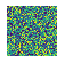

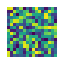

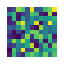

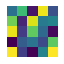

In [13]:
visnet = Net()
visnet = visnet.double()
print("Showing the weights of the first kernel in each linear layer")
for m in visnet.modules():
    if isinstance(m, nn.Linear):   
        a = m.weight.data.numpy()
#         print(tensor.max())
        c = (a - np.min(a))/np.ptp(a).astype(float)
        ncols =np.floor(np.sqrt(c.shape[1])).astype(int)
        c = np.reshape(c[0][0:ncols*ncols],(ncols,-1))
        plot_kernels(c,ncols)
#         break

##  Define a Loss function and optimizer
* Cross Entropy Loss is used as there are multiiple classes (5). 
* Different Permuation of the learning rate and optimizers were tried. The table I created for getting intition for accuracy and error can be found below or attached with homework sumission.
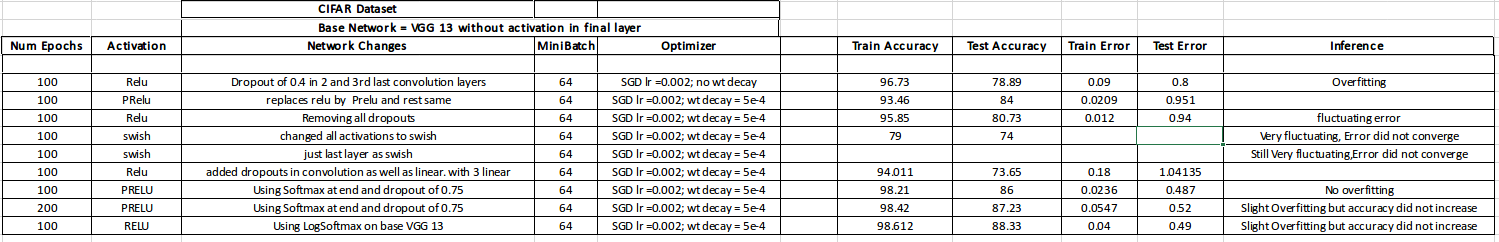
* After all the experimentation, the original vgg 13 network worked the best. Adding dropouts did not help, I guess this is due to not adding them at the right position. I also tried increasing the fully connected layers but it did not help.
* The most significant discrepancy was found that, when not using softmax layer or log softmax layer, the testing accuracy actually came out to be more. I dont know why this happened!!! 

In [14]:
import torch.optim as optim
criterion = nn.BCELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay = 5e-4)
optimizer = optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay= 5e-4)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]
best_acc= 0  # best test accuracy


In [15]:
device

'cuda'

In [16]:
# # # For Debugging
# var=0
# for batch_idx, (data, target) in enumerate(train_loader):
# #     print(batch_idx)
#     data, target = data.to(device), target.to(device)
#     output = net(data)
# #     print(target)
# # # #         print(target.dtype,output.dtype)
#     loss = criterion(output, target.flatten())
#     loss.backward()
#     optimizer.step()
#     var += (torch.sum(torch.round(output)==target.view(-1,1))).item()

#     break
# # # target

## Training and Testing Functions

In [17]:
def train(model, train_loader, optimizer, epoch,device):
#     print(criterion)
    training_loss = 0
    train_correct = 0
    lo = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        #==== Forward Pass=====
        output = model(data)
        loss = criterion(output, target.flatten())
        #=====Backward Pass=======
        loss.backward()
        optimizer.step()
        #=== Loss Append to get loss of entire Batch====
        lo.append(loss.item())
        #==== Calculating Training Accuracy========= 
        train_correct +=(torch.sum(torch.round(output)==target.view(-1,1))).item()
        #======= Logging results after every 20th batch============ 
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    #======== Getting Accuracy of the entire epoch by averaging of each batch===========    
    train_accu.append(100. * train_correct / len(train_loader.dataset))
    #======== Getting Training Loss of the epoch by averaging across each batch
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    global best_acc
    test_loss = 0
    correct = 0
    testlo = []
    with torch.no_grad(): # as we dont need to backpropogate when calculating testing error and accuracy
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #==== Getting the Prediction======
            output = model(data)
            #===== Calculating the Loss=========
            test_loss = criterion(output, target.flatten())
            testlo.append(test_loss.item())
            # Calculating Testing Accuracy for the all inputs=========
            correct += (torch.sum(torch.round(output)==target.view(-1,1))).item()
    #======= Getting Testing Accuracy for the Epoch========
    test_accu.append(100. * correct / len(test_loader.dataset))
    #====== Getting Testing Error of Epoch========
    val_loss.append(np.mean(testlo))
   #======= Logging results after every epoch ============ 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.mean(testlo), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Save checkpoint.
    acc = 100.*correct/len(test_loader.dataset)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'val_loss': val_loss,
            'test_accu': test_accu, 
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
    best_acc = acc

## Resume trained network if needed 

In [18]:
start_epoch = 0 # start from epoch 0 or last checkpoint epoch

# print('==> Resuming from checkpoint..')
# assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
# checkpoint = torch.load('./checkpoint/ckpt.t7')
# net.load_state_dict(checkpoint['net'])
# best_acc = checkpoint['acc']
# start_epoch = checkpoint['epoch']

In [ ]:
# a= net.state_dict(checkpoint['val_loss'])

# Training the Model

In [ ]:
for epoch in range(start_epoch, 500):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

/home/anirudh/detect/lib/python3.5/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Train Epoch: 0 [0/1196 (0%)]	Loss: 1.696446
Train Epoch: 0 [320/1196 (27%)]	Loss: 15.542450
Train Epoch: 0 [640/1196 (53%)]	Loss: 17.269388
Train Epoch: 0 [960/1196 (80%)]	Loss: 17.269388


/home/anirudh/detect/lib/python3.5/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))



Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Saving..
Train Epoch: 1 [0/1196 (0%)]	Loss: 8.634694
Train Epoch: 1 [320/1196 (27%)]	Loss: 17.269388
Train Epoch: 1 [640/1196 (53%)]	Loss: 12.088572
Train Epoch: 1 [960/1196 (80%)]	Loss: 15.542450

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 2 [0/1196 (0%)]	Loss: 12.088572
Train Epoch: 2 [320/1196 (27%)]	Loss: 25.904083
Train Epoch: 2 [640/1196 (53%)]	Loss: 6.907755
Train Epoch: 2 [960/1196 (80%)]	Loss: 15.542450

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 3 [0/1196 (0%)]	Loss: 6.907755
Train Epoch: 3 [320/1196 (27%)]	Loss: 13.815511
Train Epoch: 3 [640/1196 (53%)]	Loss: 22.450205
Train Epoch: 3 [960/1196 (80%)]	Loss: 12.088572

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 4 [0/1196 (0%)]	Loss: 12.088572
Train Epoch: 4 [320/1196 (27%)]	Loss: 13.815511
Train Epoch: 4 [640/1196 (53%)]	Loss: 15.542450
Train Epoch: 4 [960/1196 (80%)]	Loss: 15.542450

T

Train Epoch: 33 [960/1196 (80%)]	Loss: 13.815511

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 34 [0/1196 (0%)]	Loss: 13.815511
Train Epoch: 34 [320/1196 (27%)]	Loss: 13.815511
Train Epoch: 34 [640/1196 (53%)]	Loss: 18.996326
Train Epoch: 34 [960/1196 (80%)]	Loss: 18.996326

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 35 [0/1196 (0%)]	Loss: 15.542450
Train Epoch: 35 [320/1196 (27%)]	Loss: 12.088572
Train Epoch: 35 [640/1196 (53%)]	Loss: 15.542450
Train Epoch: 35 [960/1196 (80%)]	Loss: 12.088572

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 36 [0/1196 (0%)]	Loss: 17.269388
Train Epoch: 36 [320/1196 (27%)]	Loss: 13.815511
Train Epoch: 36 [640/1196 (53%)]	Loss: 22.450205
Train Epoch: 36 [960/1196 (80%)]	Loss: 18.996326

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 37 [0/1196 (0%)]	Loss: 18.996326
Train Epoch: 37 [320/1196 (27%)]	Loss: 18.996326
Train Epoch: 37 [640/1196 (53%)]	Loss: 12

Train Epoch: 66 [320/1196 (27%)]	Loss: 10.361633
Train Epoch: 66 [640/1196 (53%)]	Loss: 12.088572
Train Epoch: 66 [960/1196 (80%)]	Loss: 15.542450

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 67 [0/1196 (0%)]	Loss: 5.180817
Train Epoch: 67 [320/1196 (27%)]	Loss: 10.361633
Train Epoch: 67 [640/1196 (53%)]	Loss: 15.542450
Train Epoch: 67 [960/1196 (80%)]	Loss: 15.542450

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 68 [0/1196 (0%)]	Loss: 17.269388
Train Epoch: 68 [320/1196 (27%)]	Loss: 15.542450
Train Epoch: 68 [640/1196 (53%)]	Loss: 17.269388
Train Epoch: 68 [960/1196 (80%)]	Loss: 18.996326

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 69 [0/1196 (0%)]	Loss: 15.542450
Train Epoch: 69 [320/1196 (27%)]	Loss: 15.542450
Train Epoch: 69 [640/1196 (53%)]	Loss: 18.996326
Train Epoch: 69 [960/1196 (80%)]	Loss: 10.361633

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 70 [0/1196 (0%)]	Loss: 10.


Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 99 [0/1196 (0%)]	Loss: 13.815511
Train Epoch: 99 [320/1196 (27%)]	Loss: 15.542450
Train Epoch: 99 [640/1196 (53%)]	Loss: 18.996326
Train Epoch: 99 [960/1196 (80%)]	Loss: 17.269388

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 100 [0/1196 (0%)]	Loss: 8.634694
Train Epoch: 100 [320/1196 (27%)]	Loss: 15.542450
Train Epoch: 100 [640/1196 (53%)]	Loss: 15.542450
Train Epoch: 100 [960/1196 (80%)]	Loss: 8.634694

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 101 [0/1196 (0%)]	Loss: 17.269388
Train Epoch: 101 [320/1196 (27%)]	Loss: 20.723267
Train Epoch: 101 [640/1196 (53%)]	Loss: 8.634694
Train Epoch: 101 [960/1196 (80%)]	Loss: 8.634694

Test set: Average loss: 13.8155, Accuracy: 400/800 (50%)

Train Epoch: 102 [0/1196 (0%)]	Loss: 17.269388
Train Epoch: 102 [320/1196 (27%)]	Loss: 15.542450
Train Epoch: 102 [640/1196 (53%)]	Loss: 17.269388
Train Epoch: 102 [960/1196 (80%)]	

Train Epoch: 131 [320/1196 (27%)]	Loss: 0.710639
Train Epoch: 131 [640/1196 (53%)]	Loss: 0.687852
Train Epoch: 131 [960/1196 (80%)]	Loss: 0.693440

Test set: Average loss: 0.6851, Accuracy: 426/800 (53%)

Saving..
Train Epoch: 132 [0/1196 (0%)]	Loss: 0.693093
Train Epoch: 132 [320/1196 (27%)]	Loss: 0.690795
Train Epoch: 132 [640/1196 (53%)]	Loss: 0.747775
Train Epoch: 132 [960/1196 (80%)]	Loss: 0.672767

Test set: Average loss: 0.6948, Accuracy: 400/800 (50%)

Train Epoch: 133 [0/1196 (0%)]	Loss: 0.692914
Train Epoch: 133 [320/1196 (27%)]	Loss: 0.691776
Train Epoch: 133 [640/1196 (53%)]	Loss: 0.689548
Train Epoch: 133 [960/1196 (80%)]	Loss: 0.725616

Test set: Average loss: 0.7268, Accuracy: 377/800 (47%)

Train Epoch: 134 [0/1196 (0%)]	Loss: 0.736540
Train Epoch: 134 [320/1196 (27%)]	Loss: 0.600718
Train Epoch: 134 [640/1196 (53%)]	Loss: 0.652547
Train Epoch: 134 [960/1196 (80%)]	Loss: 0.679752

Test set: Average loss: 0.6865, Accuracy: 466/800 (58%)

Saving..
Train Epoch: 135 [0/1196

Train Epoch: 163 [960/1196 (80%)]	Loss: 0.723401

Test set: Average loss: 0.6817, Accuracy: 406/800 (51%)

Train Epoch: 164 [0/1196 (0%)]	Loss: 0.740328
Train Epoch: 164 [320/1196 (27%)]	Loss: 0.708135
Train Epoch: 164 [640/1196 (53%)]	Loss: 0.706670
Train Epoch: 164 [960/1196 (80%)]	Loss: 0.631699

Test set: Average loss: 0.6837, Accuracy: 447/800 (56%)

Saving..
Train Epoch: 165 [0/1196 (0%)]	Loss: 0.685693
Train Epoch: 165 [320/1196 (27%)]	Loss: 0.683216
Train Epoch: 165 [640/1196 (53%)]	Loss: 0.714080
Train Epoch: 165 [960/1196 (80%)]	Loss: 0.702355

Test set: Average loss: 0.6787, Accuracy: 413/800 (52%)

Train Epoch: 166 [0/1196 (0%)]	Loss: 0.721542
Train Epoch: 166 [320/1196 (27%)]	Loss: 0.710551
Train Epoch: 166 [640/1196 (53%)]	Loss: 0.692725
Train Epoch: 166 [960/1196 (80%)]	Loss: 0.651529

Test set: Average loss: 0.6859, Accuracy: 392/800 (49%)

Train Epoch: 167 [0/1196 (0%)]	Loss: 0.748814
Train Epoch: 167 [320/1196 (27%)]	Loss: 0.666627
Train Epoch: 167 [640/1196 (53%)]	Lo


Test set: Average loss: 0.6811, Accuracy: 417/800 (52%)

Train Epoch: 196 [0/1196 (0%)]	Loss: 0.666781
Train Epoch: 196 [320/1196 (27%)]	Loss: 0.589208
Train Epoch: 196 [640/1196 (53%)]	Loss: 0.555941
Train Epoch: 196 [960/1196 (80%)]	Loss: 1.167129

Test set: Average loss: 0.6875, Accuracy: 449/800 (56%)

Saving..
Train Epoch: 197 [0/1196 (0%)]	Loss: 0.694419
Train Epoch: 197 [320/1196 (27%)]	Loss: 0.691432
Train Epoch: 197 [640/1196 (53%)]	Loss: 0.718660
Train Epoch: 197 [960/1196 (80%)]	Loss: 0.689005

Test set: Average loss: 0.7126, Accuracy: 400/800 (50%)

Train Epoch: 198 [0/1196 (0%)]	Loss: 0.687878
Train Epoch: 198 [320/1196 (27%)]	Loss: 0.608189
Train Epoch: 198 [640/1196 (53%)]	Loss: 0.686848
Train Epoch: 198 [960/1196 (80%)]	Loss: 0.708100

Test set: Average loss: 0.6913, Accuracy: 379/800 (47%)

Train Epoch: 199 [0/1196 (0%)]	Loss: 0.667769
Train Epoch: 199 [320/1196 (27%)]	Loss: 0.703751
Train Epoch: 199 [640/1196 (53%)]	Loss: 0.644276
Train Epoch: 199 [960/1196 (80%)]	Lo

Train Epoch: 228 [320/1196 (27%)]	Loss: 0.706051
Train Epoch: 228 [640/1196 (53%)]	Loss: 0.740629
Train Epoch: 228 [960/1196 (80%)]	Loss: 0.707961

Test set: Average loss: 0.6965, Accuracy: 400/800 (50%)

Train Epoch: 229 [0/1196 (0%)]	Loss: 0.686389
Train Epoch: 229 [320/1196 (27%)]	Loss: 0.699225
Train Epoch: 229 [640/1196 (53%)]	Loss: 0.666942
Train Epoch: 229 [960/1196 (80%)]	Loss: 0.694267

Test set: Average loss: 0.6913, Accuracy: 420/800 (52%)

Saving..
Train Epoch: 230 [0/1196 (0%)]	Loss: 0.691251
Train Epoch: 230 [320/1196 (27%)]	Loss: 0.672751
Train Epoch: 230 [640/1196 (53%)]	Loss: 0.739095
Train Epoch: 230 [960/1196 (80%)]	Loss: 0.958315

Test set: Average loss: 0.6879, Accuracy: 453/800 (57%)

Saving..
Train Epoch: 231 [0/1196 (0%)]	Loss: 0.691652
Train Epoch: 231 [320/1196 (27%)]	Loss: 0.681269
Train Epoch: 231 [640/1196 (53%)]	Loss: 0.690131
Train Epoch: 231 [960/1196 (80%)]	Loss: 0.677650

Test set: Average loss: 0.6884, Accuracy: 381/800 (48%)

Train Epoch: 232 [0/1196

Train Epoch: 260 [640/1196 (53%)]	Loss: 0.685019
Train Epoch: 260 [960/1196 (80%)]	Loss: 0.676252

Test set: Average loss: 0.6787, Accuracy: 411/800 (51%)

Saving..
Train Epoch: 261 [0/1196 (0%)]	Loss: 0.706042
Train Epoch: 261 [320/1196 (27%)]	Loss: 0.696077
Train Epoch: 261 [640/1196 (53%)]	Loss: 0.731437
Train Epoch: 261 [960/1196 (80%)]	Loss: 0.699314

Test set: Average loss: 0.6876, Accuracy: 473/800 (59%)

Saving..
Train Epoch: 262 [0/1196 (0%)]	Loss: 0.690573
Train Epoch: 262 [320/1196 (27%)]	Loss: 0.685515
Train Epoch: 262 [640/1196 (53%)]	Loss: 0.782370
Train Epoch: 262 [960/1196 (80%)]	Loss: 0.654954

Test set: Average loss: 0.6947, Accuracy: 400/800 (50%)

Train Epoch: 263 [0/1196 (0%)]	Loss: 0.702470
Train Epoch: 263 [320/1196 (27%)]	Loss: 0.658937
Train Epoch: 263 [640/1196 (53%)]	Loss: 0.692327
Train Epoch: 263 [960/1196 (80%)]	Loss: 0.724800

Test set: Average loss: 0.6987, Accuracy: 394/800 (49%)

Train Epoch: 264 [0/1196 (0%)]	Loss: 0.708423
Train Epoch: 264 [320/1196 

## Resume trained network

In [ ]:
# print('==> Resuming from checkpoint..')
# assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
# checkpoint = torch.load('./checkpoint/ckpt.t7')
# net.load_state_dict(checkpoint['net'])
# best_acc = checkpoint['acc']
# start_epoch = checkpoint['epoch']

In [ ]:
start_epoch

In [ ]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', np.mean(val_loss))
print('Testing Accuracy:', np.max(test_accu))
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss ' + str(val_loss[-1]))
plt.legend()
plt.show()
plt.plot(train_accu,'r', label='Training accuracy')
plt.plot(test_accu,'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(np.max(test_accu)))
plt.legend()
plt.show()

## Inferences
* It is clear from the abive graph that, there is overfitting in the network.
* I tried different menthods like changing dropouts and actiavtion functions to do address this.
* This did not help as, even though the overfitting decreased the final test accuracy always decreased.
* Adam gave beteer performance than SGD.
* The haphazard motion of both error and accuracy is due to the random shuffling of data in minibatches after each epoch.

# Incorrect Predictions


In [ ]:
err=[]
ind=[]
predictedlabel=[]
targetlabel=[]
classlabels = ['airplane', 'automobile', 'bird', 'cat' , 'deer' , 'dog', 'frog', 'horse', 'ship', 'truck']
n = 6   # Number of False predictions to output

vis_loader = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=2)


# vis_loader = torch.utils.data.DataLoader(
#     FlowerLoader(x_test, y_test, transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.ToTensor(),
#         normalize,
#     ])), shuffle=False)

for data, target in vis_loader:
    data, target = data.to(device), target.to(device)
    #==== Getting the Prediction======
    output = net(data)
    #===== Calculating the Loss=========
    test_loss = criterion(output, target)
    err.append(test_loss.item())
    # Checking what predictions are correct========
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    predictedlabel.append(pred.item())
    targetlabel.append(target.item())
    neg = ~pred.eq(target.view_as(pred))
    ind.append(neg.item())
    
    


In [ ]:
#======= Plotting Incorrect=======
ind,err,predictedlabel,targetlabel =np.asarray(ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]

nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
num = 0
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(x_test[maxerrorind[num]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(classlabels[predictedlabel[maxerrorind[num]]],
                                                                              classlabels[targetlabel[maxerrorind[num]]]))
        num = num+1
fig.tight_layout()

## Correct Predictions

In [ ]:
#======= Plotting Correct=======

ind,err,predictedlabel,targetlabel =np.asarray(~ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]

nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
num =  0
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(x_test[maxerrorind[num]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(classlabels[predictedlabel[maxerrorind[num]]],
                                                                               classlabels[targetlabel[maxerrorind[num]]]))
        num = num + 1
fig.tight_layout()

### 2) Implementing using Local Binary Pattern

In [ ]:
from skimage import feature
import numpy as np
from sklearn.svm import LinearSVC  
import argparse
import cv2
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from keras.datasets import cifar10


In [ ]:
numPoints = 48
radius = 1
def describe(image, eps=1e-7):
# compute the Local Binary Pattern representation
# of the image, and then use the LBP representation
# to build the histogram of patterns
    lbp = feature.local_binary_pattern(image,numPoints,radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2)) 
# # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    # return the histogram of Local Binary Patterns
    return hist

In [ ]:
data = []
labels = []
for i in range(0,x_train.shape[0]):
    img = x_train[i]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hist = describe(gray)
    labels.append(y_train[i])
    data.append(hist)
#     print(hist.shape)
#     break
# np.save('train_data.npy',data)
# np.save('train_label.npy',labels)    

In [ ]:
# train a Linear SVM on the data
# data = np.load('train_data.npy')
# labels = np.load('train_label.npy')   
svclassifier = LinearSVC(tol=1e-5)  
h = svclassifier.fit(data, labels)  

In [ ]:
acc = [] 
predictlabel=[]
# loop over the testing images
for i in range(0,x_test.shape[0]):
    img = x_test[i]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hist = describe(gray)
    prediction = h.predict(hist.reshape(1, -1))
    acc.append(prediction == y_test[i])
    predictlabel.append(prediction)
acc = np.asarray(acc)*1    
print('Test Accuracy = ' + str(np.mean(acc)))

In [ ]:
## Plotting Training VS Epoch Plots
# Function taken from (Kaggle) https://www.kaggle.com/paul92s/linear-svc-classifier#


def plot_learning_curve(estimator, title, x1, y1, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x1, y1, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# title = "Learning Curves ( Linear SVM)"
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# plot_learning_curve(h, title, data, labels, cv=cv)

# plt.show()


## Incorrect Predictions

In [ ]:
index =  np.where(acc == 0)[0]
classlabels=np.asarray(classlabels) 
#======= Plotting Incorrect=======
nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
num = 0
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(x_test[index[num]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(classlabels[predictlabel[index[num]].astype(int)],
                                                                              classlabels[y_test[index[num]].astype(int)]))
        num = num+1
fig.tight_layout()

## Correct Predictions

In [ ]:
posindex =  np.where(acc == 1)[0]
#======= Plotting Incorrect=======
nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
num = 0
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(x_test[posindex[num]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(classlabels[predictlabel[posindex[num]].astype(int)],
                                                                              classlabels[y_test[posindex[num]].astype(int)]))
        num = num+1
fig.tight_layout()